In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import os
import random
import math
import pandas as pd
import scipy
import numpy.ma as ma
import itertools
from networkx.algorithms import bipartite
import community
# from infomap import infomap
import os
import rpy2.robjects as robjects

# PAGINAS PARA SACAR INFO:
### https://hackernoon.com/fight-crime-with-social-network-analysis-7a879d4a65ea
### https://leb.fbi.gov/articles/featured-articles/social-network-analysis-a-systematic-approach-for-investigating
### https://iir.adobeconnect.com/p5yuw5ulrof/?proto=true

## Descripción de Red
ROSENFELD,WHITE--ST. LOUIS CRIME
DATASETS CRIME SEX

DESCRIPTION One 870×557 two mode valued matrix of individuals by involvement in crime events. One 870×1 vector displaying the sex of each individual.

CRIME two mode, valued
SEX vector reporting sex of each individual.
BACKGROUND In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.
### Modificar los números de arriba porque la red que usamos está basada en esta descripción pero tiene 829 personas en vez de 870
#### Fuente:
http://moreno.ss.uci.edu/data.html#crime

In [2]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

In [3]:
data_total=ldata('crimen/red_crimenes')
sexos = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.sex')
nombres = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.name')
roles = ldata('crimen/moreno_crime/rel.moreno_crime_crime.person.role')

In [4]:
crimenes=[]
personas=[]
red_cr = []
usados = []
j = 0
for i in data_total:
    crimenes.append(i[1]+'cr')
    if i[0] not in usados:
        j = j + 1
        usados.append(i[0])
        personas.append(j)
    red_cr.append([j,i[1]+'cr']) # En su primer elemento contiene un número que indica a la persona.
                                 # almacenado esto mismo en lista "personas"
                                 # en su segundo elemento un str que contiene al crimen.
                                 # # almacenado esto mismo en lista "crimenes"

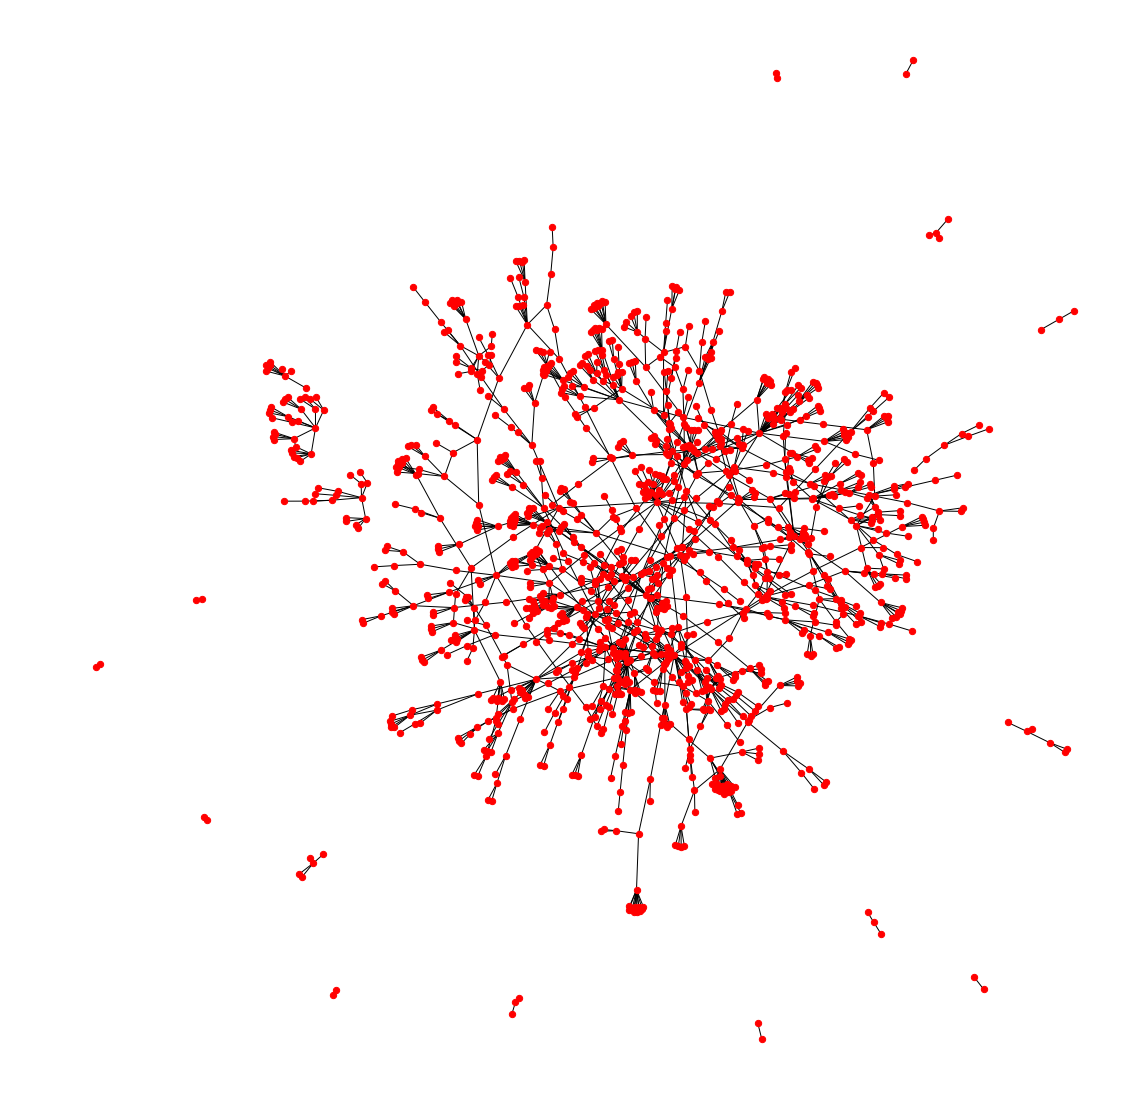

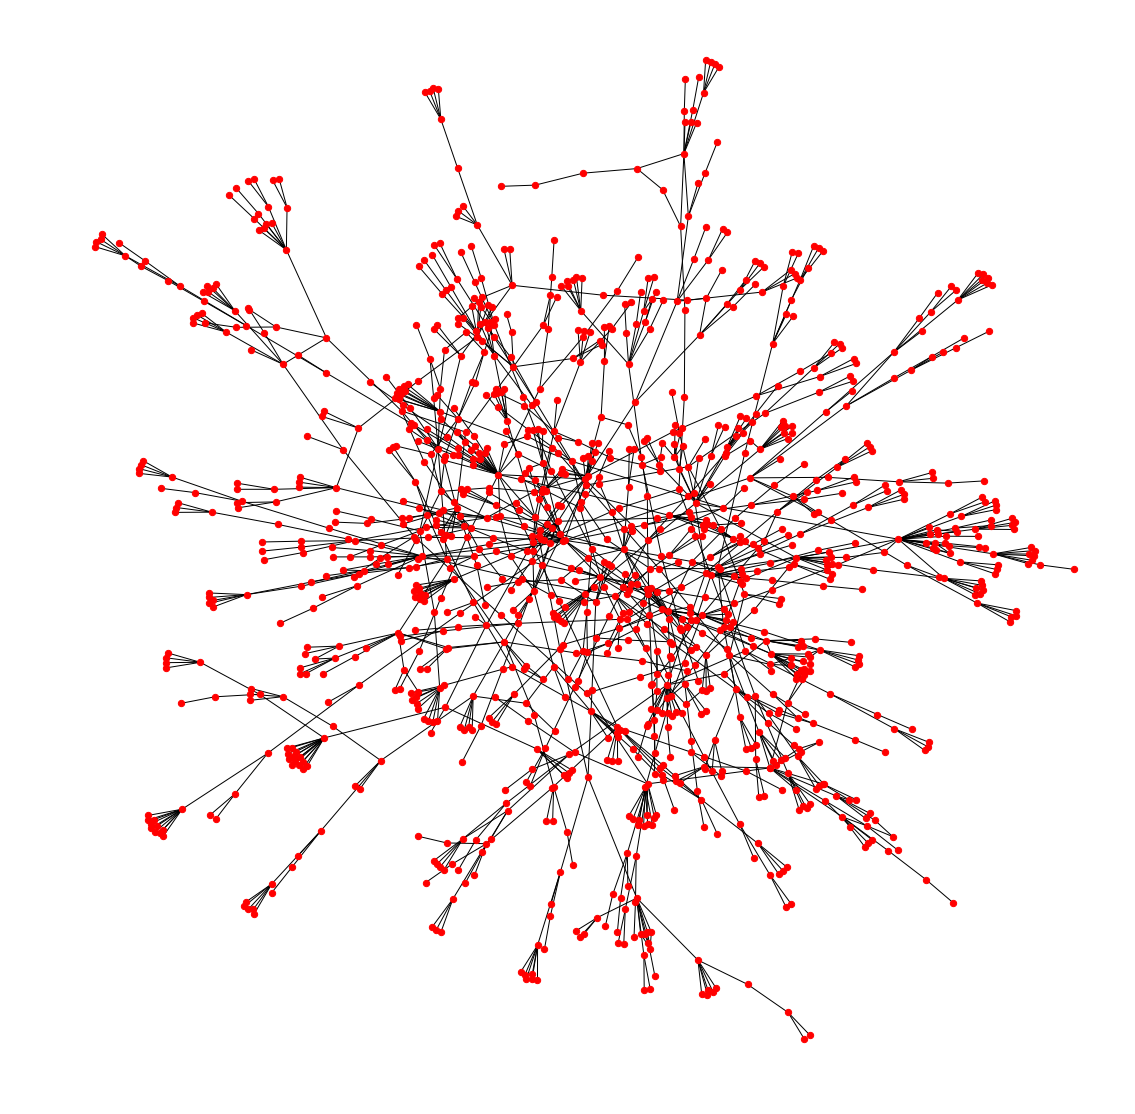

In [5]:
# Asignar esta bipartición despues nos permite armar la red persona - persona.

B = nx.Graph()
# Asigna dos valores de bipartición (0 y 1) para cada tipo de nodo (personas, crimenes)
B.add_nodes_from(personas, bipartite=0)
B.add_nodes_from(crimenes, bipartite=1)
# Agrega un enlace entre nodos de biparticiones diferentes.
B.add_edges_from(red_cr)

plt.figure(figsize=(15,15))
nx.draw(B,node_size = 40,with_labels=False, font_weight='bold')
plt.show()

Bmax = max(nx.connected_component_subgraphs(B), key=len)
plt.figure(figsize=(15,15))
nx.draw(Bmax,node_size = 40,with_labels=False, font_weight='bold')
plt.show()

In [6]:
# print(nombres[829])
#Asignacion universal de atributos (AUA)
for node in Bmax.nodes:
    if node in personas:
#         print("hola")
        Bmax.node[node]['color']='red'
        Bmax.node[node]['nombre']=nombres[node-1]
        Bmax.node[node]['rol']=roles[node-1]
        Bmax.node[node]['sexo']=sexos[node-1]
    elif node in crimenes:
#         print('FUNCIONA!!!')
        Bmax.node[node]['color']='blue'

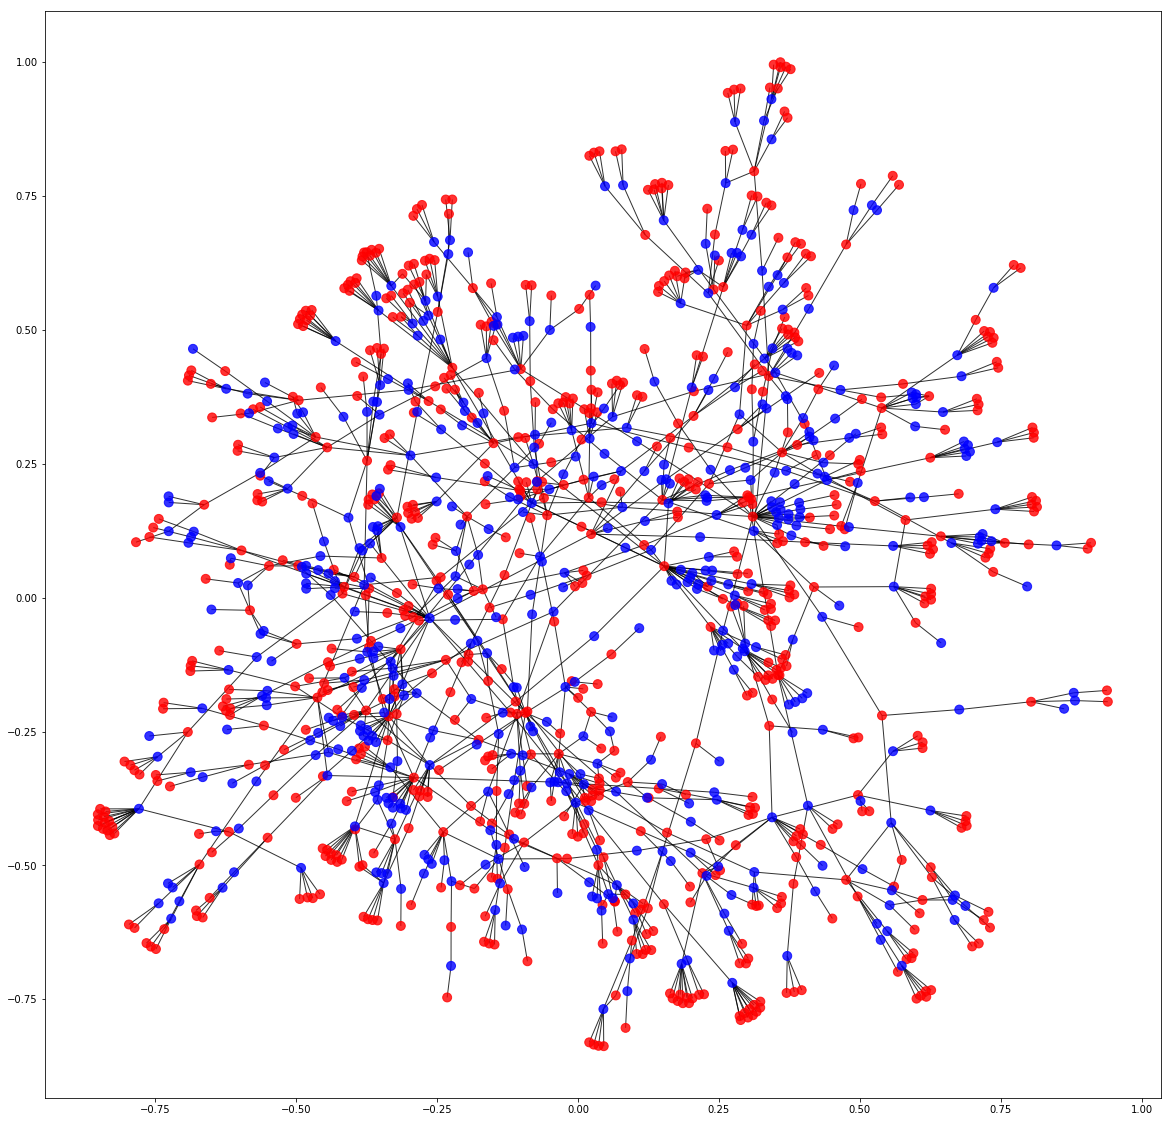

In [7]:
plt.figure(figsize=(20,20))
nx.draw_networkx(Bmax, node_color=list(nx.get_node_attributes(Bmax, "color").values()),
                 node_size=80,
                 alpha=0.8,
                 with_labels=False)
plt.show()

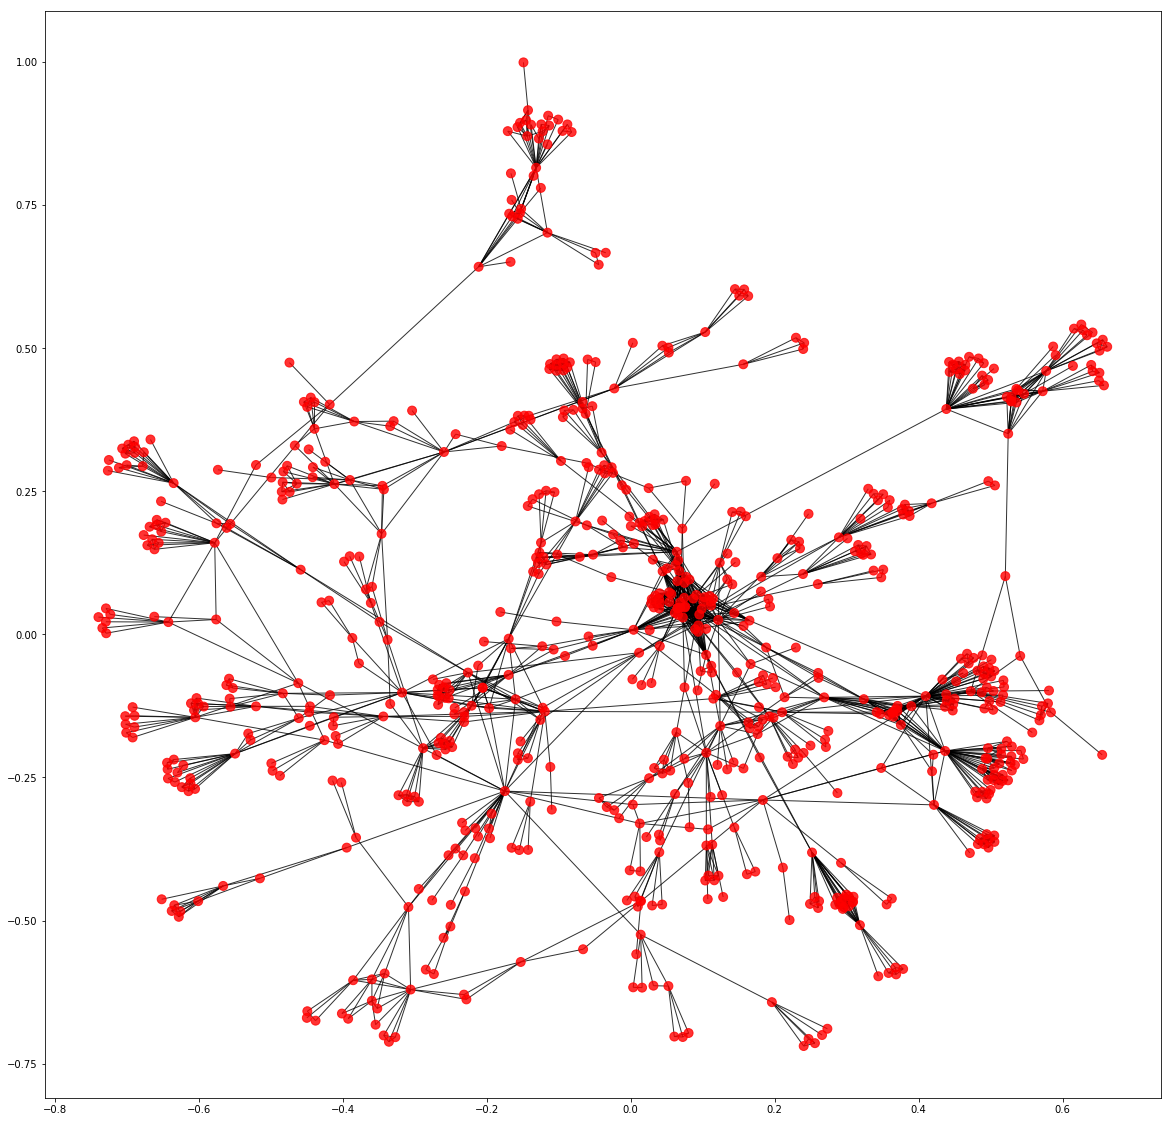

In [8]:
# Armamos la red Persona - Persona. 
# Peso de los enlaces: Nro. de vecinos compartidos (i.e. Nro. de crimenes compartidos)
# Armar con esto las comunidades --- ver lo de las componenetes gigantes

PP = max(nx.connected_component_subgraphs(nx.algorithms.bipartite.projection.weighted_projected_graph(B, personas, ratio=False)), key=len)

for node in PP.nodes:
    if node in personas:
#         print("hola")
        PP.node[node]['color']='red'
        PP.node[node]['nombre']=nombres[node-1]
        PP.node[node]['rol']=roles[node-1]
        PP.node[node]['sexo']=sexos[node-1]
    elif node in crimenes:
#         print('FUNCIONA!!!')
        PP.node[node]['color']='blue'

plt.figure(figsize=(20,20))
nx.draw_networkx(PP, node_color=list(nx.get_node_attributes(PP, "color").values()),
                 node_size=80,
                 alpha=0.8,
                 with_labels=False)
plt.show()

In [9]:
grados = nx.bipartite.degrees(Bmax, list(Bmax.nodes()), weight=None)
gpers=[]
gcrim = []
for node in Bmax.nodes:
    if node in personas:
        gpers.append(grados[1][node])
    if node in crimenes:
        gcrim.append(grados[1][node])

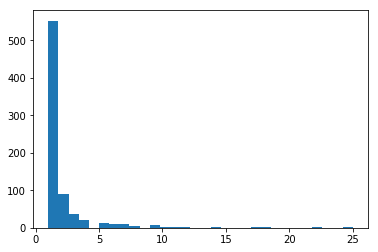

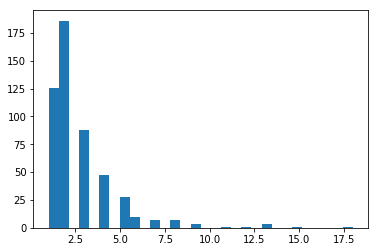

In [10]:
plt.hist(gpers,bins=30)
plt.show()

plt.hist(gcrim,bins=30)
plt.show()

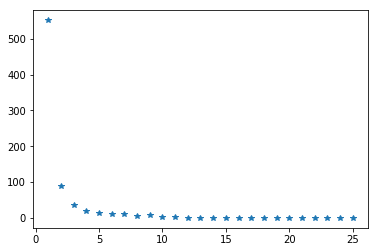

In [11]:
nro=np.linspace(1,max(gpers),max(gpers))
gradpers=np.zeros(len(nro))

for i in range(len(nro)):
    for g in gpers:
        if g==i+1:
            gradpers[i]=gradpers[i]+1
plt.plot(nro,gradpers,'*')
plt.show()

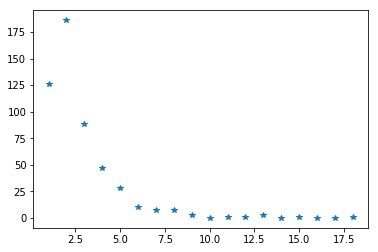

In [12]:
nrocr=np.linspace(1,max(gcrim),max(gcrim))
gradcrim=np.zeros(len(nrocr))
for i in range(len(nrocr)):
    for g in gcrim:
        if g==i+1:
            gradcrim[i]=gradcrim[i]+1
plt.plot(nrocr,gradcrim,'*')
plt.show()

In [25]:
comunidadesPP = community.best_partition(PP)
mod = community.modularity(comunidadesPP,PP)
# d,sil = silhouette1(PP,comunidadesPP)

In [26]:
def silhouette1(g,dic):
    a = []
    b = []
    S = []
    sil ={}
    for node in g.nodes:
        dist_b = []
        dist_a = []
        minn = min(list(dic.values()))
        maxx = max(list(dic.values()))

        for i in range(minn,maxx+1):
            dist_b.append([])

        for vecino,atri in dic.items():
            if atri == dic[node] and node != vecino and vecino in nx.node_connected_component(g,node):
                dist_a.append(nx.shortest_path_length(g, source=node, target=vecino, weight=None))

            elif node != vecino and vecino in nx.node_connected_component(g,node):
                dist_b[atri-minn].append(nx.shortest_path_length(g, source=node, target=vecino, weight=None))

        dist_b.remove(dist_b[dic[node]-minn])
        
        if len(dist_a) == 0:
                a_prom = 0
        else:
            a_prom = sum(dist_a)/len(dist_a)

        a.append(a_prom)

        b_prom = []
        for i in range(len(dist_b)):
            b_prom.append(sum(dist_b[i])/len(dist_b[i]))

        b.append(min(b_prom))
        
        sil[node]=(min(b_prom)-a_prom)/max(min(b_prom),a_prom) #diccionario

        S.append([node,(min(b_prom)-a_prom)/max(min(b_prom),a_prom)])
     

    Sprom = 0
    for i in range(len(S)):
        Sprom = Sprom + S[i][1]/len(S)

    return sil,Sprom

In [33]:
def grafico_sil(g,dic,sil,S,u):
    
    label = ['Louvain','Fast Greedy','Betweenness','Infomap']
    
#     sil,S = silhouette(g,dic)
#     print(type(sil))
    valores = []

    for i in range(min(list(dic.values())),max(list(dic.values()))+1):
        valores2=[]
        for node in g.nodes:
#             print(sil[node])
            if dic[node] == i:
                valores2.append([node,sil[node]])
        valores2.sort(key=lambda cluster: cluster[1], reverse=True)
        valores.append(valores2)
    
    xdata=[]
    ydata=[]
    xo=0
    w=1
    for i in range(len(valores)):
        x=np.zeros(len(valores[i])+1)
        y=np.zeros(len(valores[i])+1)
        t=-1
        x[0]=xo
        
        for j in range(len(valores[i])):
#             l=l+1
#             S=S+valores[i][j][1]
            x[j+1]=x[j]+1
            y[j]=y[j]+valores[i][j][1]
        x[len(valores[i])]=x[len(valores[i])-1]+1
        xo=x[len(valores[i])]+1
        xdata.append(x)
        ydata.append(y)
        
#     S=S/l
#     print(xdata)
    for i in range(len(valores)):
        plt.bar(xdata[i],ydata[i], width=w, bottom=None)
    plt.axhline(y=S,linewidth=1, color='r', linestyle='dashed',label=round(S,4))
    plt.legend()
    plt.title(label[u]+'- Silhouette')
#     plt.savefig ("Silhouette_"+label[u]+".png")
    plt.show()

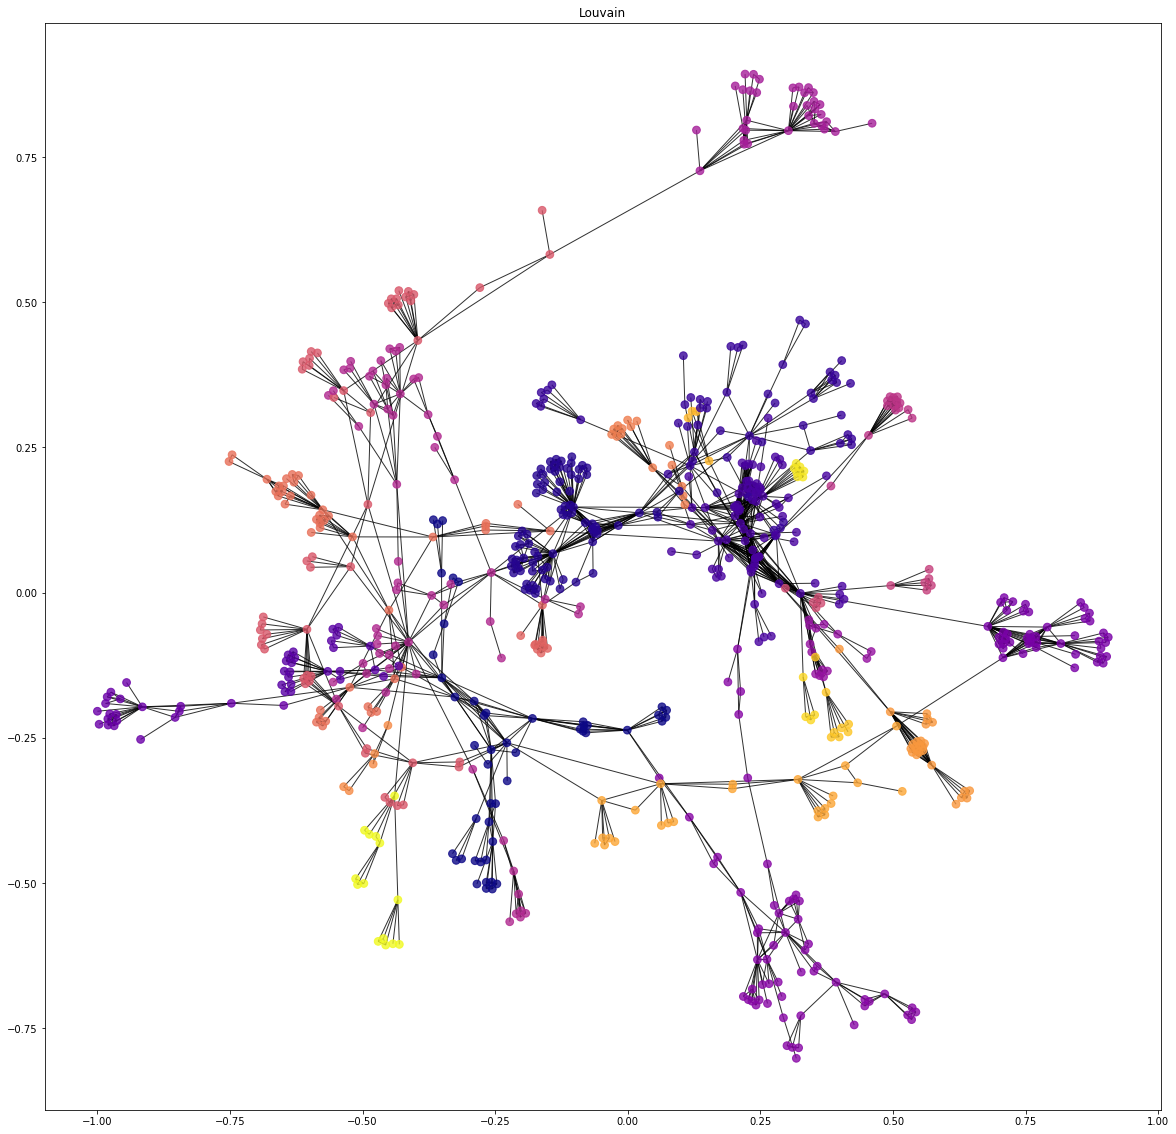

In [28]:
plt.figure(figsize=(20,20))
for name,label in comunidadesPP.items():
    PP.nodes()[name]["color"] = label

nx.draw_networkx(PP, cmap=plt.get_cmap('plasma'),
                 node_color=list(nx.get_node_attributes(PP, "color").values()),
                 node_size=60,
                 alpha=0.8,
                 with_labels=False)
plt.title('Louvain')
# plt.savefig ("Particion_Louvain.png")
plt.show()


In [29]:
d,sil = silhouette1(PP,comunidadesPP)

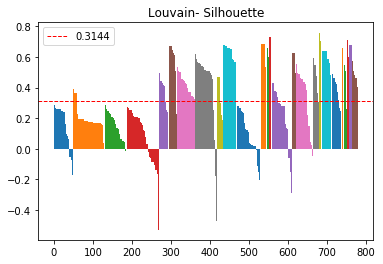

In [34]:
grafico_sil(PP,comunidadesPP,d,sil,0)

## Cosas Para Hacer
* Analizar la centralidad de los actores usando 
    * Grado
    * Betweenness Centrality
    * Coeficiente de Clustering Local
* Una forma interesante de presentar la red (al menos para la proxima presentación) es hacer el grafo poniendole grosor a los enlaces en la red PP de acuerdo a su peso, y dándole el tamaño a los nodos de acuerdo a su centralidad (una idea sería comparar los tres grafos, en los cuales los tamaños de los nodos dependen del parámetro de centralidad, es decir, grado, betweenness o clustering)
* "Co-offending data can easily be acquired from criminal records (if one has the rights to those, of course). In a co-offending graph, there is an undirected connection between two individuals, if they committed a crime together. Relationships between individuals should be weighted, as probably some pairs appeared multiple times in the criminal record" (sacado de https://hackernoon.com/fight-crime-with-social-network-analysis-7a879d4a65ea). Lo que nos dice este párrafo es que podemos analizar el vínculo entre personas y verificar que aquellas con enlaces más pesados tienden a ser sospechosos, pues participaron en más crímenes de manera conjunta (como bien quería hacer Juan)

## ¿Hacia dónde podemos enfocar el trabajo? (para Juan)
* Con toda esta data se me ocurre que podemos simular el análisis de los papers que subí, tratando de dar correlación entre la centralidad de un nodo y su probabilidad de que sea sospechoso (no encontré por ahora en ningún lado información de redes con culpables, y de hecho en muchas páginas dicen que esta información es confidencial, o sea, difícil acceso, pero tranquilamente se puede serguir buscando). A esto le podemos agregar lo que querías hacer en el mensaje que me mandaste ayer a la noche.
    * O sea que parte de nuestro análisis sería comparar las distintas medidas de centralidad y ver que pueden significar
* Lo que habría que ver mejor es el tema de las comunidades, o sea, en caso de usarlo, tratar de darle un significado más caido a tierra, como, ¿por qué nos interesaría observar comunidades? ¿Qué significa la presencia de las mismas? Un poco lo habíamos hablado pero bueno, tratar de profundizar más
* Ver paper de gonza